# Chapter 3

- Geocode addresses
- Join
- Point in polygon queries
- Which addresses in a district
- Spatial join `sjoin`

>Ray casting algorithm
> - cast a ray from the point
> - count the number of times the ray intersects the polygon
> - if the ray intersects an odd number of times, the point is in the polygon

In [2]:
import pandas as pd

In [9]:
DDIR = '../data/agis/data/'

In [3]:
addresses = pd.read_csv('../data/agis/data/helsinki_addresses/addresses.txt', 
                       sep=';')
addresses.head()

,id,addr
0,1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


In [4]:
import geopandas as gpd

geocoded_addresses = gpd.tools.geocode(
    addresses["addr"],
    provider="nominatim",
    user_agent="autogis2023",
    timeout=10
)
geocoded_addresses.head()



,geometry,address
0,POINT (24.91556 60.1632),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns..."
1,POINT (24.93009 60.16846),"1, Kampinkuja, Kamppi, Eteläinen suurpiiri, He..."
2,POINT (24.94153 60.17016),"Espresso House, 8, Kaivokatu, Keskusta, Kluuvi..."
3,POINT (24.97687 60.18748),"Kalasatama, 1, Hermannin rantatie, Suvilahti, ..."
4,POINT (24.92151 60.15662),"9, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E..."


In [6]:
geocoded_addresses_with_id = geocoded_addresses.join(addresses)
geocoded_addresses_with_id.iloc[0]

geometry                        POINT (24.9155624 60.1632015)
address     Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...
id                                                       1000
addr                 Itämerenkatu 14, 00101 Helsinki, Finland
Name: 0, dtype: object

In [7]:
geocoded_addresses_with_id.to_file('../data/local/addresses.gpkg')

In [10]:
city_districts = gpd.read_file(DDIR + 'helsinki_city_districts/helsinki_city_districts_2021.gpkg')

In [11]:
city_districts.head()

,name,geometry
0,Eteläinen,"POLYGON ((24.7828 60.09996, 24.80437 60.07607,..."
1,Läntinen,"POLYGON ((24.8314 60.25406, 24.83168 60.25321,..."
2,Keskinen,"POLYGON ((24.93345 60.18317, 24.93502 60.18005..."
3,Pohjoinen,"POLYGON ((24.90081 60.23526, 24.89944 60.235, ..."
4,Koillinen,"POLYGON ((24.97163 60.24253, 24.97163 60.24246..."


<Axes: >

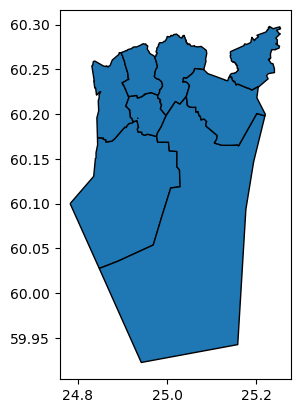

In [13]:
city_districts.plot(ec='k')

>Which addresses are in ‘Eteläinen' (southern) district

In [14]:
southern_district = city_districts[city_districts.name == 'Eteläinen']
southern_district

,name,geometry
0,Eteläinen,"POLYGON ((24.7828 60.09996, 24.80437 60.07607,..."


In [17]:
addresses = gpd.read_file('../data/local/addresses.gpkg')

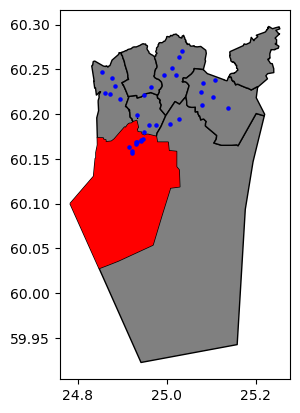

In [22]:
ax = city_districts.plot(fc='grey', ec='k')
southern_district.plot(ax=ax, fc='red')
addresses.plot(ax=ax, c='b', markersize=5);

>The geometry must be fixed to a single polygon, otherwise
>within performs a row-wise comparison

In [26]:
addresses.within(southern_district.at[0, 'geometry']).head()

0     True
1     True
2     True
3    False
4     True
dtype: bool

In [27]:
addresses_in_the_southern_district = addresses[
    addresses.within(southern_district.at[0, 'geometry'])
]
addresses_in_the_southern_district

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.1632)
1,"1, Kampinkuja, Kamppi, Eteläinen suurpiiri, He...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93009 60.16846)
2,"Espresso House, 8, Kaivokatu, Keskusta, Kluuvi...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94153 60.17016)
4,"9, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92151 60.15662)
10,"Rautatientori, Keskusta, Kluuvi, Eteläinen suu...",1011,"Rautatientori 1, 00100 Helsinki, Finland",POINT (24.94263 60.1709)
30,"Kampin keskus, 1, Urho Kekkosen katu, Kamppi, ...",1031,"Urho Kekkosen katu 1, 00100 Helsinki, Finland",POINT (24.93307 60.16908)
31,"Ruoholahdenkatu, Kamppi, Eteläinen suurpiiri, ...",1032,"Ruoholahdenkatu 17, 00101 Helsinki, Finland",POINT (24.93031 60.16642)
32,"3, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...",1033,"Tyynenmerenkatu 3, 00220 Helsinki, Finland",POINT (24.92121 60.15878)
33,"Old Tea Shop, 4, Vilhonkatu, Kaisaniemi, Kluuv...",1034,"Vilhonkatu 4, 00101 Helsinki, Finland",POINT (24.94683 60.172)


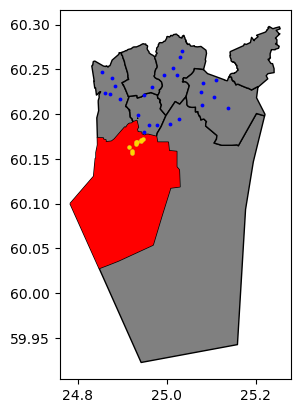

In [28]:
ax = city_districts.plot(fc='grey', ec='k')
southern_district.plot(ax=ax, fc='red')
addresses.plot(ax=ax, c='b', markersize=3)
addresses_in_the_southern_district.plot(ax=ax, color='gold', markersize=5);

In [38]:
population_grid_source = gpd.read_file(
    (
        "https://kartta.hsy.fi/geoserver/wfs"
        "?service=wfs"
        "&version=2.0.0"
        "&request=GetFeature"
        "&typeName=asuminen_ja_maankaytto:Vaestotietoruudukko_2020"
        "&srsName=EPSG:3879"
    ),
)

In [39]:
population_grid_source.crs = "EPSG:3879"

In [40]:
population_grid_source.crs

<Projected CRS: EPSG:3879>
Name: ETRS89 / GK25FIN
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Finland - nominally onshore between 24°30'E and 25°30'E but may be used in adjacent areas if a municipality chooses to use one zone over its whole extent.
- bounds: (24.5, 59.94, 25.5, 68.9)
Coordinate Operation:
- name: Finland Gauss-Kruger zone 25
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [41]:
population_grid_source.head()

,gml_id,index,asukkaita,asvaljyys,ika0_9,ika10_19,ika20_29,ika30_39,ika40_49,ika50_59,ika60_69,ika70_79,ika_yli80,geometry
0,Vaestotietoruudukko_2020.1,703,5,51,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
1,Vaestotietoruudukko_2020.2,710,8,44,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
2,Vaestotietoruudukko_2020.3,711,5,90,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
3,Vaestotietoruudukko_2020.4,715,13,34,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6682998.998, 25472499.9..."
4,Vaestotietoruudukko_2020.5,848,5,53,99,99,99,99,99,99,99,99,99,"POLYGON ((25472749.993 6690249.003, 25472749.9..."


In [46]:
population_grid = gpd.read_file(
    "https://avoidatastr.blob.core.windows.net/avoindata/AvoinData/"
    "6_Asuminen/Vaestotietoruudukko/Shp/Vaestotietoruudukko_2021_shp.zip"
)

In [47]:
population_grid.head()

,INDEX,ASUKKAITA,ASVALJYYS,IKA0_9,IKA10_19,IKA20_29,IKA30_39,IKA40_49,IKA50_59,IKA60_69,IKA70_79,IKA_YLI80,geometry
0,688,5,50.60,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6689749.005, 25472499.9..."
1,703,7,36.71,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
2,710,8,44.50,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
3,711,7,64.14,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
4,715,11,41.09,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6682998.998, 25472499.9..."


In [48]:
population_grid = population_grid[['ASUKKAITA', 'geometry']]
population_grid = population_grid.rename(columns={"ASUKKAITA": "population"})

In [49]:
population_grid.head()

,population,geometry
0,5,"POLYGON ((25472499.995 6689749.005, 25472499.9..."
1,7,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
2,8,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
3,7,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
4,11,"POLYGON ((25472499.995 6682998.998, 25472499.9..."


In [50]:
population_grid['population_density'] = (
    population_grid['population'] / (population_grid.area / 1e6)
)
population_grid.head()

,population,geometry,population_density
0,5,"POLYGON ((25472499.995 6689749.005, 25472499.9...",80.001048
1,7,"POLYGON ((25472499.995 6685998.998, 25472499.9...",112.001467
2,8,"POLYGON ((25472499.995 6684249.004, 25472499.9...",128.001677
3,7,"POLYGON ((25472499.995 6683999.005, 25472499.9...",112.001467
4,11,"POLYGON ((25472499.995 6682998.998, 25472499.9...",176.002305


In [52]:
population_grid.crs == addresses.crs

False

In [53]:
population_grid = population_grid.to_crs(addresses.crs)

In [54]:
addresses_with_population_data = addresses.sjoin(
    population_grid, how='left', predicate='within'
)
addresses_with_population_data.head()

,address,id,addr,geometry,index_right,population,population_density
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.1632),3262.0,505.0,8080.105832
1,"1, Kampinkuja, Kamppi, Eteläinen suurpiiri, He...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93009 60.16846),3381.0,172.0,2752.036046
2,"Espresso House, 8, Kaivokatu, Keskusta, Kluuvi...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94153 60.17016),3504.0,43.0,688.009011
3,"Kalasatama, 1, Hermannin rantatie, Suvilahti, ...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97687 60.18748),NaN,NaN,NaN
4,"9, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92151 60.15662),3310.0,1402.0,22431.538035


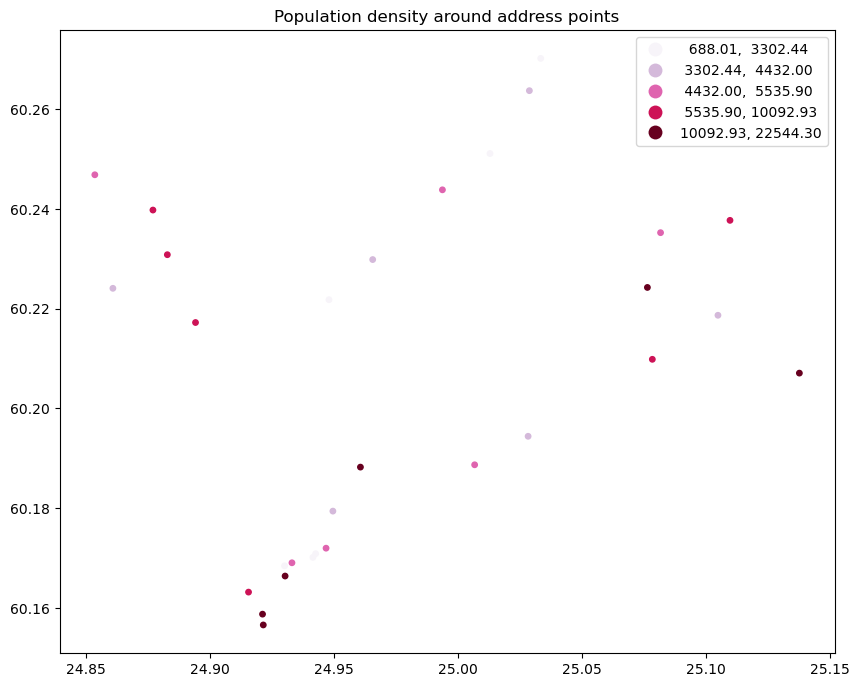

In [57]:
ax = addresses_with_population_data.plot(
    figsize=(10,10), 
    column='population_density', 
    cmap='PuRd', 
    scheme='quantiles', 
    markersize=15, 
    legend=True
)
ax.set_title("Population density around address points");

Text(0.5, 1.0, 'Population density in the Helsinki metropolitan area')

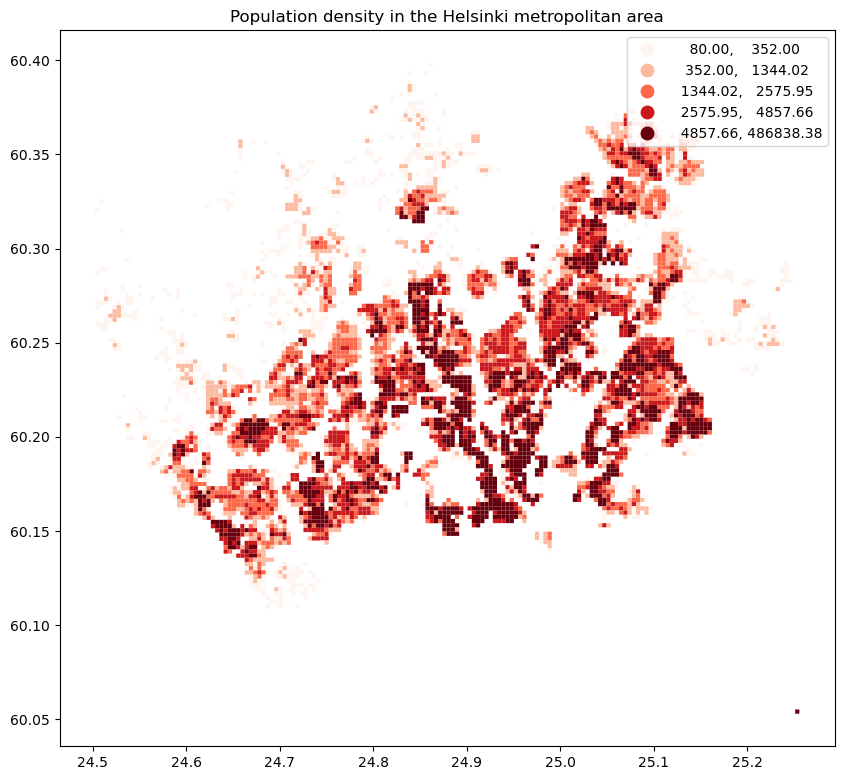

In [59]:
ax = population_grid.plot(
    figsize=(10, 10),
    column="population_density",
    cmap="Reds",
    scheme="quantiles",
    legend=True
)
ax.set_title("Population density in the Helsinki metropolitan area")

In [60]:
addresses_with_population_data.to_file(
    '../data/local/addresses.gpkg', 
    layer='addresses_with_population_data'
)